In [319]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf.pbc import gto

In [2]:
from pyscf.pbc.tools import fft,ifft
from pyscf.pbc import df
def G_vector(cell):
    x=np.fft.fftfreq(cell.mesh[0],1/cell.mesh[0])
    y=np.fft.fftfreq(cell.mesh[1],1/cell.mesh[1])
    z=np.fft.fftfreq(cell.mesh[2],1/cell.mesh[2])
    b=cell.reciprocal_vectors()
    Gs=[]
    for i in x:
        for j in y:
            for k in z:
                Gs.append(i*b[0]+j*b[1]+k*b[2])
    return np.array(Gs)

def get_aoG_values(cell,images):
    ao = get_ao(cell,images)
    nao = ao.shape[1]
    ao_G = []

    image_sum=(2*images[0]+1)*(2*images[1]+1)*(2*images[2]+1)
    for i in range(nao):
        ao_G.append(cell.vol/8/image_sum*fft(ao[:,i],cell.mesh)) 
    ao_G = np.array(ao_G).T
    return ao_G

def overlap3(cell,images):
    ao_G = get_aoG_values(cell,images)
    weight = 1/cell.vol
    overlap = np.einsum('xy,xz->yz',ao_G.conj(), ao_G,optimize=True)*weight
    return np.real(overlap)

In [3]:
def get_grids(cell):
    grids_x = np.arange(cell.cell.mesh[0]) / cell.cell.mesh[0]
    grids_y = np.arange(cell.cell.mesh[1]) / cell.cell.mesh[1]
    grids_z = np.arange(cell.mesh[2]) / cell.mesh[2]
    grids=[]
    for x in range(cell.mesh[0]):
        for y in range(cell.mesh[1]):
            for z in range(cell.mesh[2]):
                grid=np.einsum('i,ij->j', (grids_x[x], grids_y[y], grids_z[z]), cell.a)
                grids.append(grid)
    return np.array(grids)

def get_lattice(cell, images):
    Ls=[]
    for x in range(-images[0], images[0]+1):
        for y in range(-images[1], images[1]+1):
            for z in range(-images[2], images[2]+1):
                L = np.einsum('i,ij->j', (x, y, z), cell.a)
                Ls.append(L)    
    return np.array(Ls)

In [322]:
def get_ao_with_kpt(cell,k,grids):
    cell=cell.copy()
    Ls=get_lattice(cell,images)
    atom=cell.atom_coords()
    ao=0
    for L in Ls:
        cell.atom=[['He',atom[0]+L]]
        #cell.atom=[['Li',atom[0]+L],['Li',atom[1]+L]]
        cell.build()
        phase_fac=np.exp(1j*np.sum(k*L))
        ao+=cell.eval_gto('GTOval',grids)*phase_fac
    return ao

def get_AORs(cell,kpts,grids):
    AORs=[]
    for i in range(len(kpts)):
        kpt=kpts[i]
        AORs.append(get_ao_with_kpt(cell,kpt,grids))
    return np.array(AORs)

In [1]:
Lenth = 4
Mesh = 80
Image = 3
images= [Image]*3
cell = gto.Cell()
cell.a = np.eye(3)*Lenth
cell.atom = 'Li 2 2 2','Li 0 0 0'
cell.mesh = np.array([Mesh]*3)
cell.unit = 'Bohr'
cell.basis = '6-31g'
cell.build()

grids=get_grids(cell)

kpts=cell.make_kpts([2,2,2])
AORs=get_AORs(cell,kpts,grids)

NameError: name 'gto' is not defined

In [ ]:
Lenth = 4
Mesh = 50
Image = 2
images= [Image]*3
cell = gto.Cell()
cell.a = np.eye(3)*Lenth
cell.atom = 'He 2 2 2'
cell.mesh = np.array([Mesh]*3)
cell.unit = 'Bohr'
cell.basis = 'unc-sto-3g'
cell.build()

grids=get_grids(cell)

kpts=cell.make_kpts([2,2,2])
AORs=get_AORs(cell,kpts,grids)

In [6]:
def get_aoG_with_kpt(cell,k,grids):
    aoR=get_ao_with_kpt(cell,k,grids)
    phase_fac=np.exp(-1j*np.sum(cell.atom_coords()*G_vector(cell),axis=1))
    #phase_fac=np.exp(-1j*np.sum(k*grids,axis=1))
    
    n_ao=len(aoR[0])
    aoG=[]
    
    image_sum=(2*images[0]+1)*(2*images[1]+1)*(2*images[2]+1)
    for i in range(n_ao):
        aoG.append(cell.vol/8/image_sum*fft(aoR[:,i]*phase_fac,cell.mesh))
    aoG=np.transpose(ao_G)
    return aoG

def get_aoG_values_ref(cell, kpt):
    from pyscf.pbc import df
    return df.ft_ao.ft_ao(cell, G_vector(cell), kpt=kpt)

In [23]:
def get_ovlp_2k(cell,ao_k1,ao_k2,grids):
    w=cell.vol/(cell.mesh[0]*cell.mesh[1]*cell.mesh[2])
    #ao_k1=get_ao_with_kpt(cell,k1,grids)
    #ao_k2=get_ao_with_kpt(cell,k2,grids)
    J=w*np.einsum('xi,xj->ij',ao_k1.conj(),ao_k2)
    return np.array(J)

def get_ovlp_kpts(cell,AORs,grids):
    w=cell.vol/(cell.mesh[0]*cell.mesh[1]*cell.mesh[2])
    J=[]
    for i in range(len(AORs)):
        ao_k=AORs[i]
        J.append(get_ovlp_2k(cell,ao_k,ao_k,grids))
    return np.array(J)

In [8]:
def get_kinetic_kpts(cell,kpts,grids,AORs):
    n_ao=len(AORs[0,0])
    N=cell.mesh[0]*cell.mesh[1]*cell.mesh[2]
    dx=cell.a[0,0]/cell.mesh[0]
    dy=cell.a[1,1]/cell.mesh[1]
    dz=cell.a[2,2]/cell.mesh[2]
    
    ao2=[]
    for i in range(n_ao):
        ao1=AORs[i].reshape(cell.mesh[0],cell.mesh[1],cell.mesh[2],n_ao)
        print(ao1.shape)
        x=ao1[:,:,:,i]
        ao2.append(np.gradient(x))
    ao2=np.array(ao2)

    ao3_dx=[]
    ao3_dy=[]
    ao3_dz=[]

    for i in range(n_ao):
        
        ao3_dx.append(ao2[i,0].reshape(N,1)/dx)
        ao3_dy.append(ao2[i,1].reshape(N,1)/dy)
        ao3_dz.append(ao2[i,2].reshape(N,1)/dz)
    ao3_dx=np.array(ao3_dx)
    ao3_dy=np.array(ao3_dy)
    ao3_dz=np.array(ao3_dz)
    print(ao3_dx.shape)

    w=cell.vol/(cell.mesh[0]*cell.mesh[1]*cell.mesh[2])
    T=[]
    for i in range(len(AORs)):
        T.append(0.5*w*(np.einsum('ixk,jxk->ijk',ao3_dx.conjugate(),ao3_dx)+\
                       np.einsum('ixk,jxk->ijk',ao3_dy.conjugate(),ao3_dy)+\
                       np.einsum('ixk,jxk->ijk',ao3_dz.conjugate(),ao3_dz)))
    T=np.array(T)
    print(T.shape)
    return T[:,:,:,0]

In [250]:
def get_kinetic_kpt(cell,aoR):
    n_ao=len(aoR[0])
    N=cell.mesh[0]*cell.mesh[1]*cell.mesh[2]
    w=cell.vol/N
    ao1=aoR.reshape(cell.mesh[0],cell.mesh[1],cell.mesh[2],n_ao)
    dx=cell.a[0,0]/cell.mesh[0]
    dy=cell.a[1,1]/cell.mesh[1]
    dz=cell.a[2,2]/cell.mesh[2]
    
    ao_dx=[]
    ao_dy=[]
    ao_dz=[]
    
    for i in range(n_ao):
        X=np.array(np.gradient(ao1[:,:,:,i]))
        ao_dx.append(X[0]/dx)
        ao_dy.append(X[1]/dy)
        ao_dz.append(X[2]/dz)
        
    ao_dx=np.array(ao_dx).reshape(n_ao,N)
    ao_dy=np.array(ao_dy).reshape(n_ao,N)
    ao_dz=np.array(ao_dz).reshape(n_ao,N)
    
    T=[]
    T.append(0.5*w*(np.einsum('ix,jx->ij',ao_dx.conjugate(),ao_dx)+\
                  np.einsum('ix,jx->ij',ao_dy.conjugate(),ao_dy)+\
                  np.einsum('ix,jx->ij',ao_dz.conjugate(),ao_dz)))
    T=np.array(T)
    return T[0].real

In [239]:
def get_kinetic_kpts(cell,kpts,grids,AORs):
    Tk=[]
    for i in range(len(AORs)):
        Tk.append(get_kinetic_kpt(cell,AORs[i]))
    return np.array(Tk).real

In [254]:
def get_kinetic_kpts_no(cell,kpts,grids,AORs):
    n_ao=len(AORs[0,0])
    N=cell.mesh[0]*cell.mesh[1]*cell.mesh[2]
    dx=cell.a[0,0]/cell.mesh[0]
    dy=cell.a[1,1]/cell.mesh[1]
    dz=cell.a[2,2]/cell.mesh[2]
    
    ao1=[]
    for i in range(len(AORs)):
        ao1.append(AORs[i].reshape(n_ao,cell.mesh[0],cell.mesh[1],cell.mesh[2]))
    ao1=np.array(ao1)
    print(ao1.shape)
    
    ao2=[]
    for i in range(len(AORs)):
        x=ao1[i]
        x=np.array(x)
        print(x.shape)
        
        ao21=[]
        for j in range(n_ao):
            x=ao1[i,j,:,:,:]
            x=np.array(x)
            ao21.append(np.gradient(x))
        ao21=np.array(ao21)
        #print(ao21.shape)
        ao2.append(ao21)
    ao2=np.array(ao2)
    print(ao2.shape)
    ao2=ao2.reshape(len(AORs),n_ao,3,N)
    print(ao2.shape)
    
    ao3_dx=ao2[:,:,0,:]/dx
    ao3_dy=ao2[:,:,0,:]/dy
    ao3_dz=ao2[:,:,0,:]/dz
    
    print(ao3_dz.shape,len(ao2[0]))

    w=cell.vol/(cell.mesh[0]*cell.mesh[1]*cell.mesh[2])
    T=[]
    for i in range(len(AORs)):
        T.append(0.5*w*(np.einsum('xik,xjk->ij',ao3_dx.conjugate(),ao3_dx)+\
                       np.einsum('xik,xjk->ij',ao3_dy.conjugate(),ao3_dy)+\
                       np.einsum('xik,xjk->ij',ao3_dz.conjugate(),ao3_dz)))
        #T.append(0.5*w*(np.einsum('ixk,jxk->ij',ao3_dx.conjugate(),ao3_dx)+\
         #              np.einsum('ixk,jxk->ij',ao3_dy.conjugate(),ao3_dy)+\
          #             np.einsum('ixk,jxk->ij',ao3_dz.conjugate(),ao3_dz)))
    T=np.array(T)
    print(T.shape)
    return T

In [10]:
def get_Vne_kpts(cell,kpts,grids,AORs):
    Gv=G_vector(cell)
    phase_fac=np.exp(-1j*np.sum(cell.atom_coords()*Gv,axis=1))
    
    s2=np.sum(Gv**2,axis=1)
    G2=4*np.pi/s2
    G2[np.where(s2==0)[0]]=0
    V_n_G=-cell.atom_charges()[0]*phase_fac*G2    

    Vne=[]
    for i in range(len(kpts)):
        kpt=kpts[i]
        aoR=AORs[i]
        n_ao=len(aoR[0])
        
        aoR_ij=np.einsum('xi,xj->xij',aoR.conjugate(),aoR)
        aoG_ij=np.transpose(ifft(np.transpose(\
                aoR_ij.reshape(-1,n_ao**2)),cell.mesh)).reshape(-1,n_ao,n_ao)

        Vne.append(np.tensordot(V_n_G,aoG_ij,axes=([0],[0])))
    return np.array(Vne)

In [76]:
def get_j_kpts(cell,dm,kpts,grids,AORs):
    rhoe=get_density(cell,AORs,dm)

    w=cell.vol/(cell.mesh[0]*cell.mesh[1]*cell.mesh[2])
    rhoG=fft(rhoe,cell.mesh)*w
    
    s2=np.sum(G_vector(cell)**2,axis=1)
    G2=4*np.pi/s2
    G2[np.where(s2==0)[0]]=0

    vj_kpts=[]
    n_ao=AORs.shape[-1]
    for i in range(len(AORs)):
        aoR=AORs[i]
        #print(n_ao)
        aoR_ij=np.einsum('xi,xj->xij',aoR.conjugate(),aoR)
        aoG_ij=np.transpose(ifft(np.transpose(\
                aoR_ij.reshape(-1,n_ao**2)),cell.mesh)).reshape(-1,n_ao,n_ao)
        #aoG_ij=ifft(aoR_ij.reshape(-1,n_ao**2).T,cell.mesh).T.reshape(-1,n_ao,n_ao)*cell.vol
        vj_kpts.append(np.einsum('x,x,xij->ij',rhoG,G2,aoG_ij))
    return np.array(vj_kpts).real

def get_j_ref(cell, dm, kpts1, kpts2):
    from pyscf.pbc import scf
    return scf.KRHF(cell, kpts1).get_j(cell, dm, kpts=kpts1, kpts_band=kpts2)

In [68]:
def get_vxc_kpts(cell,dm,xc,kpts,AORs):
    from pyscf.dft import libxc
    rho=get_density(cell,AORs,dm)

    e_xc,v_xc=libxc.eval_xc(xc,rho,deriv=1)[:2]
    v_xc=v_xc[0]
    w=cell.vol/(cell.mesh[0]*cell.mesh[1]*cell.mesh[2])
    Exc=np.sum(rho*e_xc)*w

    vxc = []
    for i in range(len(kpts)):
        aoR=AORs[i]
        aoR_ij=np.einsum('xi,xj->xij',aoR.conjugate(),aoR)
        vxc.append(w*np.einsum('xij,x->ij',aoR_ij,v_xc))
    return np.array(vxc),Exc

def get_vxc_ref(cell, dm, xc, kpts1, kpts2):
    from pyscf.pbc import dft
    mf = dft.KRKS(cell, kpts1)
    E_xc, vxc = mf._numint.nr_rks(cell, mf.grids, xc, dm, kpts=kpts1,
                                  kpts_band=kpts2)[1:]
    return vxc, E_xc

In [258]:
def hcore_kpts(cell,kpts,grids,AORs):
    T=get_kinetic_kpts(cell,kpts,grids,AORs)
    #T=get_kinetic_ref(cell, kpts)
    V=get_Vne_kpts(cell,kpts,grids,AORs)
    #V=get_nuc_ref(cell, kpts)
    
    T=np.array(T)
    V=np.array(V)
    return T.real+V.real

In [65]:
def get_density(cell,AORs,dm):
    rho=np.zeros(cell.mesh[0]*cell.mesh[1]*cell.mesh[2],dtype=np.complex)
    for i in range(len(AORs)):
        aoR=AORs[i]
        #print(dm[0].shape)
        aoR_ij=np.einsum('xi,xj->xij',aoR.conjugate(),aoR)
        rho+=np.einsum('xij,ji->x',aoR_ij,dm[i])/len(AORs)
    return rho.real

In [326]:
def get_bands(cell,grids,kpts,AORs,xc,dm):
    nelectron=cell.nelectron
    nocc=nelectron//2

    S=get_ovlp_kpts(cell,AORs,grids)
    hcore=hcore_kpts(cell,kpts,grids,AORs)
    vxc,Exc=get_vxc_kpts(cell,dm,xc,kpts,AORs)
    vj=get_j_kpts(cell,dm,kpts,grids,AORs)
    
    Hmtx=hcore+vj+vxc
    band=[]
    for k in range(len(kpts)):
        e,c=scipy.linalg.eigh(Hmtx[k],S[k])
        band.append(e)
    return np.array(band)

In [256]:
def get_ovlp_ref(cell, kpts):
    return cell.pbc_intor('int1e_ovlp', kpts=kpts)

def get_kinetic_ref(cell, kpts):
    return cell.pbc_intor('int1e_kin', kpts=kpts)
get_kinetic = get_kinetic_ref

def get_nuc_ref(cell, kpts):
    from pyscf.pbc import df
    return np.array(df.FFTDF(cell, kpts).get_nuc(kpts))

def get_hcore_ref(cell, kpts):
    t = get_kinetic_ref(cell, kpts)
    v = get_nuc_ref(cell, kpts)
    return t + v

def get_vxc_ref(cell, dm, xc, kpts1, kpts2):
    from pyscf.pbc import dft
    mf = dft.KRKS(cell, kpts1)
    E_xc, vxc = mf._numint.nr_rks(cell, mf.grids, 'lda,vwn', dm, kpts=kpts1,
                                  kpts_band=kpts2)[1:]
    return vxc, E_xc

In [324]:
%%time
import scipy.linalg
nelectron=cell.nelectron
nocc=nelectron//2
nkpts=len(kpts)
hcore=hcore_kpts(cell,kpts,grids,AORs)
S=get_ovlp_kpts(cell,AORs,grids)
dm=np.zeros_like(S)
vxc,Exc=get_vxc_kpts(cell,dm,'lda',kpts,AORs)
vj=get_j_kpts(cell,dm,kpts,grids,AORs)

E_ewald=cell.ewald()
E=E_ewald
dE=1
cycle=0
while dE>1e-4:
    cycle+=1
    Elast=E
    Hmtx=hcore+vj+vxc
    e_k=[]
    c_k=[]
    for k in range(nkpts):
        e,c=scipy.linalg.eigh(Hmtx[k],S[k])
        e_k.append(e)
        c_k.append(c)
    e_k=np.array(e_k)
    c_k=np.array(c_k)
    fermi=np.sort(e_k.ravel())[nkpts*nocc-1]
    
    dm=[]
    for i in range(nkpts):
        dm.append(np.transpose(c_k[i]).conjugate()*c_k[i])
    dm=np.array(dm).real

    vxc,Exc=get_vxc_kpts(cell,dm,'lda',kpts,AORs)
    vj=get_j_kpts(cell,dm,kpts,grids,AORs)

    E_coul=0.5*np.einsum('kij,kji',vj,dm)/nkpts
    E_elec=np.einsum('kij,kji',hcore,dm)/nkpts+E_coul+Exc
    E=E_ewald+E_elec
    E=E.real
    dE=abs(E-Elast)
    print('SCF cycle', cycle, 'E(HF) =', round(E,3),\
          'E_coul =', round(E_coul.real,3),'Exc =',round(Exc,5) ,\
          'Ecore = ',round((np.einsum('kij,kji', hcore, dm) / nkpts).real,3) ,\
          'dE =', dE)

<ipython-input-10-a41fd7cd46a1>:6: RuntimeWarning: divide by zero encountered in true_divide
  G2=4*np.pi/s2
<ipython-input-65-7d341690c570>:2: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rho=np.zeros(cell.mesh[0]*cell.mesh[1]*cell.mesh[2],dtype=np.complex)
<ipython-input-76-3fe7c9166970>:8: RuntimeWarning: divide by zero encountered in true_divide
  G2=4*np.pi/s2


SCF cycle 1 E(HF) = 1.392 E_coul = 0.455 Exc = -0.00283 Ecore =  2.358 dE = 2.8102048104738677
SCF cycle 2 E(HF) = 0.753 E_coul = 0.323 Exc = -0.00681 Ecore =  1.856 dE = 0.6382219076726066
SCF cycle 3 E(HF) = 0.779 E_coul = 0.316 Exc = -0.0063 Ecore =  1.888 dE = 0.025675833082111854
SCF cycle 4 E(HF) = 0.776 E_coul = 0.313 Exc = -0.00619 Ecore =  1.888 dE = 0.002844092411617538
SCF cycle 5 E(HF) = 0.776 E_coul = 0.313 Exc = -0.00617 Ecore =  1.888 dE = 0.0001545401942277813
SCF cycle 6 E(HF) = 0.776 E_coul = 0.313 Exc = -0.00617 Ecore =  1.888 dE = 3.23036558125267e-05
CPU times: user 27.3 s, sys: 1.4 s, total: 28.7 s
Wall time: 25.3 s


In [325]:
%%time
nelectron = cell.nelectron
nocc = nelectron // 2
nkpts = len(kpts)

hcore = get_hcore_ref(cell, kpts)
s = get_ovlp_ref(cell, kpts)
dm = np.zeros_like(s)
vxc, Exc = get_vxc_ref(cell, dm, 'lda', kpts, kpts)
vj = get_j_ref(cell, dm, kpts, kpts)

E_ewald = cell.ewald()
E = E_ewald
dE = 1e99

cycle = 0
while dE > 1e-4:
    cycle += 1
    Elast = E

    fock = hcore + vj + vxc
    e_k = []
    c_k = []
    for k in range(nkpts):
        e, c = scipy.linalg.eigh(fock[k], s[k])
        e_k.append(e)
        c_k.append(c)
    e_k = np.array(e_k)
    c_k = np.array(c_k)
    fermi = np.sort(e_k.ravel())[nkpts*nocc-1]
    dm=[]
    for i in range(nkpts):
        dm.append(np.transpose(c_k[i]).conjugate()*c_k[i])
    dm=np.array(dm).real

    vxc, Exc = get_vxc_ref(cell, dm, 'lda', kpts, kpts)
    vj = get_j_ref(cell, dm, kpts, kpts)

    E_coul = .5 * np.einsum('kij,kji', vj, dm) / nkpts
    E_elec = np.einsum('kij,kji', hcore, dm) / nkpts + E_coul + Exc
    E = E_ewald + E_elec
    E = E.real
    dE = abs(E - Elast)
    print('SCF cycle', cycle, 'E(HF) =', round(E,3),\
          'E_coul =', round(E_coul.real,3),'Exc =',round(Exc,5) ,\
          'Ecore = ',round((np.einsum('kij,kji', hcore, dm) / nkpts).real,3) ,\
          'dE =', dE)

SCF cycle 1 E(HF) = 1.356 E_coul = 0.418 Exc = -0.00342 Ecore =  2.36 dE = 2.7741495244534873
SCF cycle 2 E(HF) = 0.721 E_coul = 0.279 Exc = -0.00824 Ecore =  1.869 dE = 0.6340215744799047
SCF cycle 3 E(HF) = 0.779 E_coul = 0.276 Exc = -0.00721 Ecore =  1.93 dE = 0.05773258152301697
SCF cycle 4 E(HF) = 0.776 E_coul = 0.273 Exc = -0.00704 Ecore =  1.929 dE = 0.0027742042490901397
SCF cycle 5 E(HF) = 0.777 E_coul = 0.273 Exc = -0.00701 Ecore =  1.93 dE = 0.0004306803047957608
SCF cycle 6 E(HF) = 0.777 E_coul = 0.273 Exc = -0.00701 Ecore =  1.93 dE = 2.7626927279644775e-05
CPU times: user 17.2 s, sys: 1.05 s, total: 18.2 s
Wall time: 12.3 s


In [ ]:
band=get_bands(cell,grids,kpts,AORs,'lda',dm)

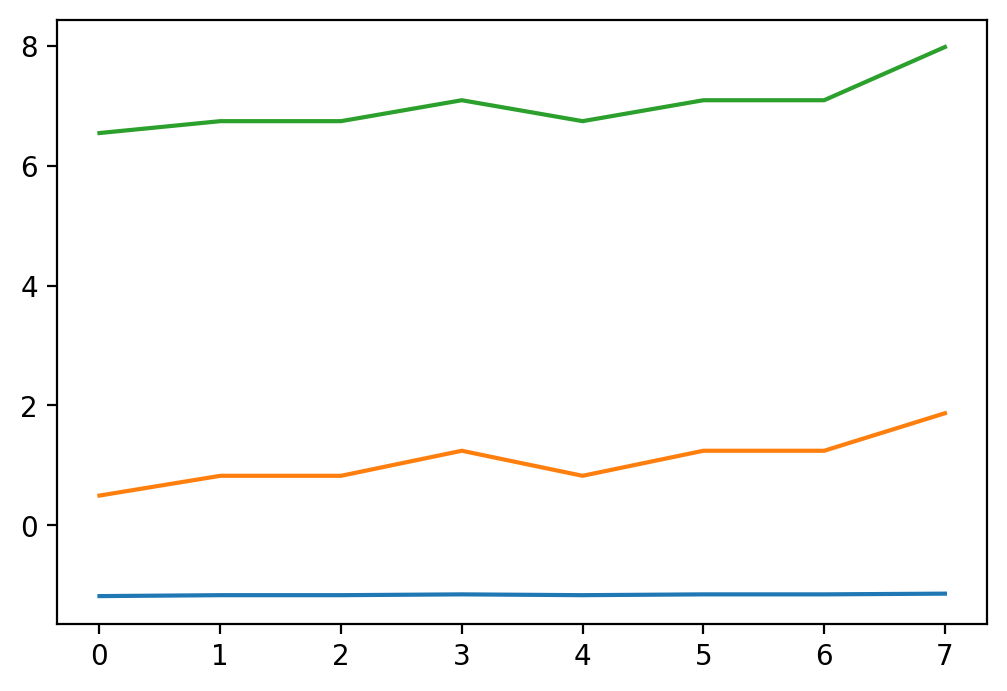

In [328]:
plt.figure(dpi=200)
for i in range(len(band[0])):
    plt.plot(np.arange(len(kpts)),band[:,i])